In [3]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import resample

# Image and Data Processing Libraries
from PIL import Image
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Vision Models
import torchvision.models as models

# Transformations Libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Weights and Biases (WandB)
import wandb
from sklearn.metrics import accuracy_score


In [4]:
df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
random_state = 4747

In [4]:
df.describe()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC
count,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000
mean,0.111133,0.669496,0.051323,0.032651,0.109735,0.011483,0.014179
std,0.314313,0.470418,0.220667,0.177730,0.312575,0.106546,0.118233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
dtypes: float64(7), object(1)
memory usage: 626.1+ KB


In [6]:
df.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')

* Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC),
* basal cell carcinoma (BCC),
*  benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL),
*  dermatofibroma (DF),
*  melanoma (MEL),
*  melanocytic nevi (NV)
*  vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC).

1. Actinic Keratoses and Intraepithelial Carcinoma / Bowen's Disease (AKIEC)
Актинічний кератоз (AK): Це передраковий стан, спричинений хронічним впливом ультрафіолетового випромінювання (УФ). Виявляється у вигляді шорстких, лускатих ділянок шкіри, що зазвичай виникають на відкритих частинах тіла, таких як обличчя, шия, руки. AK може трансформуватися у плоскоклітинний рак шкіри.
Хвороба Боуена (in situ плоскоклітинний рак): Це рання форма раку шкіри, яка локалізується у верхньому шарі шкіри (епідермісі). Вона може згодом стати інвазивним плоскоклітинним раком, якщо не лікувати.
2. Basal Cell Carcinoma (BCC)
Базальноклітинна карцинома: Це найпоширеніший вид раку шкіри, але водночас найменш агресивний. BCC зазвичай виникає через довготривалий вплив УФ-променів і розвивається дуже повільно. Може мати вигляд перлиноподібних вузликів або виразок, які не загоюються. BCC рідко метастазує, але може спричинити локальне пошкодження тканин.
3. Benign Keratosis-like Lesions (BKL)
Доброякісні кератозоподібні ураження: Це неракові утворення, що включають такі стани, як:
Сонячні лентиго (solar lentigines): Пігментні плями, які з’являються через вплив сонця. Часто виникають у людей старшого віку.
Себорейний кератоз (seborrheic keratosis): Доброякісні ураження шкіри, які зазвичай мають вигляд бородавок або плям, що можуть бути пігментованими.
Кератози ліхеноподібні (lichen-planus-like keratosis): Це окремий вид уражень, які мають певні схожості з актиничними кератозами.
4. Dermatofibroma (DF)
Дерматофіброма: Це доброякісне ураження шкіри, що зазвичай виглядає як маленька, тверда вузликова структура. Вони не є небезпечними і рідко потребують лікування, але можуть бути видалені з естетичних причин або у випадку дискомфорту.
5. Melanoma (MEL)
Меланома: Один із найбільш небезпечних видів раку шкіри, який виникає з пігментних клітин — меланоцитів. Меланома може розвиватися на шкірі або на слизових оболонках. Це агресивний вид раку, який може швидко метастазувати до інших органів. Раннє виявлення значно покращує прогноз лікування.
6. Melanocytic Nevi (NV)
Меланоцитарні невуси (родимки): Це скупчення меланоцитів у певних ділянках шкіри. Більшість невусів є доброякісними і не вимагають лікування, але деякі можуть мати потенціал перетворитися на меланому, особливо якщо є ознаки зміни їхньої форми, кольору або розміру.
7. Vascular Lesions (VASC)
Судинні ураження: Це група уражень, пов’язаних з аномаліями судин, до яких відносяться:
Ангіоми: Доброякісні пухлини, які розвиваються з кровоносних судин.
Ангіокератоми: Доброякісні судинні утворення, які зазвичай виникають на шкірі.
Піогенні гранульоми: Вони можуть розвинутися після травм і виглядають як червоні або рожеві вузлики, часто кровоточать.
Геморагії: Ураження, пов’язані з крововиливом в шкіру або під неї.
Кожен із цих станів вимагає ретельної діагностики, особливо для диференціації доброякісних утворень від злоякісних.

In [6]:
for col in ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']:
    print(f'{col}: {df[col].sum()}')

MEL: 1113.0
NV: 6705.0
BCC: 514.0
AKIEC: 327.0
BKL: 1099.0
DF: 115.0
VASC: 142.0


In [7]:
df['Sum of row'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=1)

In [9]:

df.describe()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,Sum of row
count,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.0
mean,0.111133,0.669496,0.051323,0.032651,0.109735,0.011483,0.014179,1.0
std,0.314313,0.470418,0.220667,0.177730,0.312575,0.106546,0.118233,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


# Creating dataset

In [8]:
def create_balanced_datasets(df, total_photos, val_size, test_size, random_state=4747):
    labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    
    # Create "target" column for stratification
    df['target'] = df[labels].idxmax(axis=1)
    
    # Calculate the max number of photos per class based on the total number of photos
    max_photos_per_class = total_photos // len(labels)
    
    # Create a balanced dataset without oversampling
    balanced_df = pd.DataFrame()

    # For each label, sample the appropriate number of photos
    for label in labels:
        label_df = df[df['target'] == label]
        # Sample up to max_photos_per_class for each label
        num_photos_to_take = min(len(label_df), max_photos_per_class)
        balanced_df = pd.concat([balanced_df, label_df.sample(n=num_photos_to_take, random_state=random_state)], axis=0)
    
    # Split the balanced dataset into train (3000 photos) and a combined validation/test set (1000 photos)
    train_df, temp_df = train_test_split(
        balanced_df, 
        test_size=(val_size + test_size), 
        random_state=random_state, 
        stratify=balanced_df['target']
    )

    # Ensure that the train set has exactly 3000 photos
    remaining_photos_needed = total_photos - len(train_df)
    if remaining_photos_needed > 0:
        # Proportional sampling from the balanced dataset to maintain class distribution
        additional_photos = balanced_df.groupby('target').apply(
            lambda x: x.sample(n=int(remaining_photos_needed * len(x) / len(balanced_df)), random_state=random_state)
        ).reset_index(drop=True)
        
        train_df = pd.concat([train_df, additional_photos])

    # Split the remaining data into validation and test sets with stratification
    val_df, test_df = train_test_split(
        temp_df, 
        test_size=test_size / (val_size + test_size), 
        random_state=random_state, 
        stratify=temp_df['target']
    )

    # If validation set is smaller than needed, sample proportionally from train
    val_remaining = val_size - len(val_df)
    if val_remaining > 0:
        # Sample proportionally based on class distribution in the train set
        additional_val = train_df.groupby('target').apply(
            lambda x: x.sample(n=int(val_remaining * len(x) / len(train_df)), random_state=random_state)
        ).reset_index(drop=True)
        
        val_df = pd.concat([val_df, additional_val])
        train_df = train_df[~train_df.index.isin(val_df.index)]  # Remove sampled items from train

    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, val_df, test_df

In [9]:
# Define the total number of photos you want (4000 photos)
total_photos = 4000

# Define the size of the validation and test sets (e.g., 500 for validation and 500 for testing)
val_size = 500
test_size = 300

# Call the function
train_df, val_df, test_df = create_balanced_datasets(df, total_photos, val_size, test_size, random_state=4747)


Train set size: 3998
Validation set size: 500
Test set size: 300


/tmp/ipykernel_36/3019085498.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  additional_photos = balanced_df.groupby('target').apply(


In [10]:
train_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,Sum of row,target
3815,ISIC_0028121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,BKL
8567,ISIC_0032873,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MEL
7489,ISIC_0031795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MEL
1162,ISIC_0025468,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NV
5816,ISIC_0030122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MEL
...,...,...,...,...,...,...,...,...,...,...
1982,ISIC_0029448,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,VASC
1983,ISIC_0034196,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,VASC
1984,ISIC_0030070,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,VASC
1985,ISIC_0033450,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,VASC


In [11]:
train_df = train_df.drop(['Sum of row'], axis=1)
val_df = val_df.drop(['Sum of row'], axis=1)
test_df = test_df.drop(['Sum of row'], axis=1)

In [12]:
class SkinLesionClassificationDataset(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir, transform=None):
        """
        Dataset for skin lesion classification (cutting out according to the mask).
        
        csv_file: path to the CSV file with image information and class labels.
        image_dir: directory containing the images.
        mask_dir: directory containing the masks (segmentations).
        transform: transformations applied to images.
        """
        self.annotations = csv_file
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.annotations = self.annotations.reset_index(drop=True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Read image and mask filenames
        img_name = os.path.join(self.image_dir, self.annotations.loc[idx, 'image'] + '.jpg')
        mask_name = os.path.join(self.mask_dir, self.annotations.loc[idx, 'image'] + '_segmentation.png')
        
        # Load image and mask
        image = cv2.imread(img_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            raise FileNotFoundError(f"File not found: {img_name} or {mask_name}")
    
        # Apply mask to crop the image
        masked_image = self.apply_mask(image, mask)
        
        # Read the class label (one-hot vector) and convert to class index
        label = self.annotations.loc[idx, ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
        label = label.argmax()  # Find the label with the highest value
    
        # Apply transformations if they exist
        if self.transform:
            # Apply transformations to the image
            transformed = self.transform(image=masked_image)
            masked_image = transformed['image'] 
    
        return masked_image, label

    def get_summary(self):
        """
        Returns a summary of the dataset.
        """
        summary = {
            "Total Samples": len(self),
            "Class Distribution": self.annotations[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum().to_dict()
        }
        return summary

    def get_sample(self, idx):
        """
        Returns an image and label by index.
        """
        return self.__getitem__(idx)
    
    def apply_mask(self, image, mask):
        """
        Crops the image area corresponding to the mask.
        
        image: the skin lesion image
        mask: the segmentation mask
        
        Returns the cropped area.
        """
        # Mask should be binary (black and white)
        mask = (mask > 0).astype(np.uint8)
        
        # Use the mask to crop only the relevant part of the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        # Define the area where the mask is not empty
        coords = cv2.findNonZero(mask)
        x, y, w, h = cv2.boundingRect(coords)  # Find the bounding rectangle
        
        # Crop the image based on the bounding box
        cropped_image = masked_image[y:y+h, x:x+w]
        
        return cropped_image

In [13]:
transform_classification = A.Compose([
    A.Resize(height=600, width=450),  # Resize to 600x450
    A.Blur(blur_limit=1, p=0.3),  # Add blur with a 30% chance
    A.ShiftScaleRotate(shift_limit=0.01, rotate_limit=5, p=0.3, border_mode=cv2.BORDER_CONSTANT),  # Small shift, scale, and rotate
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),  # Slight brightness and contrast change
    A.ToFloat(max_value=255),  # Normalize to float between 0 and 1 without clipping at 255
    ToTensorV2()  # Convert image to PyTorch tensor
])


In [14]:
mask_dir =  '/kaggle/input/ham1000-segmentation-and-classification/masks/'
image_dir = '/kaggle/input/ham1000-segmentation-and-classification/images/'

train_df_dataset = SkinLesionClassificationDataset(train_df, image_dir, mask_dir, transform=transform_classification)
val_df_dataset = SkinLesionClassificationDataset(val_df, image_dir, mask_dir, transform=transform_classification)
test_df_dataset = SkinLesionClassificationDataset(test_df, image_dir, mask_dir, transform=transform_classification)

In [15]:
train_df_dataset[800]

(tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],
 
         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],
 
         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ...,

In [16]:
train_summary = train_df_dataset.get_summary()
print(train_summary)

{'Total Samples': 3998, 'Class Distribution': {'MEL': 812.0, 'NV': 812.0, 'BCC': 731.0, 'AKIEC': 465.0, 'BKL': 813.0, 'DF': 163.0, 'VASC': 202.0}}


In [17]:
print(val_df_dataset.get_summary())

{'Total Samples': 500, 'Class Distribution': {'MEL': 102.0, 'NV': 102.0, 'BCC': 91.0, 'AKIEC': 58.0, 'BKL': 101.0, 'DF': 21.0, 'VASC': 25.0}}


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['target']), y=train_df['target'])
class_weights_dict = dict(enumerate(class_weights))
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [19]:
val_summary = val_df_dataset.get_summary()
print(val_summary)

{'Total Samples': 500, 'Class Distribution': {'MEL': 102.0, 'NV': 102.0, 'BCC': 91.0, 'AKIEC': 58.0, 'BKL': 101.0, 'DF': 21.0, 'VASC': 25.0}}


In [20]:
test_summary = test_df_dataset.get_summary()
print(test_summary)

{'Total Samples': 300, 'Class Distribution': {'MEL': 61.0, 'NV': 61.0, 'BCC': 55.0, 'AKIEC': 35.0, 'BKL': 61.0, 'DF': 12.0, 'VASC': 15.0}}


In [21]:
print(train_df_dataset.annotations.index)

RangeIndex(start=0, stop=3998, step=1)


In [22]:
def show_image_with_label(image, label):
    """
    Displays an image with its corresponding label.
    
    image: The image to be displayed.
    label: The label corresponding to the image.
    """
    # Check if image is a tensor and convert it to numpy
    if isinstance(image, np.ndarray):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image.permute(1, 2, 0)  # Change from CHW to HWC
        image_rgb = image.cpu().numpy()  # Convert to numpy
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
    
    # Create the label text (you can modify the class names here)
    class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    label_name = class_names[label]

    # Display the image with the label as the title
    plt.imshow(image_rgb)
    plt.title(f"Label: {label_name}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

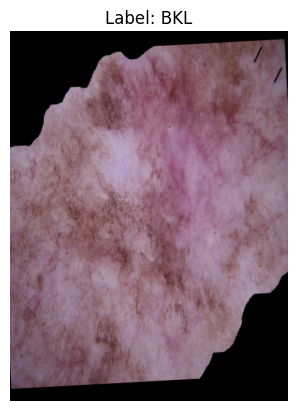

In [23]:
image, label = train_df_dataset[0]  # This returns the masked image and label

# Display the image with its label
show_image_with_label(image, label)

# MODELS

In [24]:
!wandb login 492953ddcda0576b6e6ebf89860aed0ccd177efe

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
run_name = f"alex net, batch=16, lr=0.001, 4000 photos"

In [26]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Skin cancer detection",

    # track hyperparameters and run metadata
    config={
    "epochs" : 50,
    "batch_size" : 16,
    "learning_rate" : 0.001,
    },
    name=run_name
)

wandb: Currently logged in as: kkaterynabilyk (kkaterynabilyk-lviv-polytechnic-national-university). Use `wandb login --relogin` to force relogin


In [27]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, config, device):
    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = running_loss / len(train_loader)
        f1, recall, precision, accuracy = calculate_metrics(all_labels, all_preds)  # Без include_accuracy
        wandb.log({"epoch": epoch + 1, "loss": avg_loss, "f1_score": f1, "recall": recall, "precision": precision, "accuracy": accuracy})
        print(f'Epoch [{epoch+1}/{config.epochs}], Loss: {avg_loss:.4f}, F1-score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}')
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_preds, val_labels_list = [], []
        
        with torch.no_grad():
            for val_images, batch_labels in val_loader:
                val_images, batch_labels = val_images.to(device), batch_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, batch_labels)
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_preds.extend(val_predicted.cpu().numpy())
                val_labels_list.extend(batch_labels.cpu().numpy())

        avg_val_loss = val_running_loss / len(val_loader)
        val_f1, val_recall, val_precision, val_accuracy = calculate_metrics(val_labels_list, val_preds)  # Без include_accuracy
        wandb.log({"val_loss": avg_val_loss, "val_f1_score": val_f1, "val_recall": val_recall, "val_precision": val_precision, "val_accuracy": val_accuracy})
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation F1-score: {val_f1:.4f}, Validation Recall: {val_recall:.4f}, Validation Precision: {val_precision:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Learning Rate Scheduler
        scheduler.step(avg_val_loss)
        
        # Early Stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

# ResNet50

In [37]:
class SkinLesionClassifier_Resnet50(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_Resnet50, self).__init__()
        self.freeze_base = freeze_base
        
        self.base_model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            for param in self.base_model.layer4.parameters():
                param.requires_grad = True
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )
         
    def forward(self, x):
        return self.base_model(x)

In [29]:
# def calculate_metrics(y_true, y_pred):
#     precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
#     recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
#     f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
#     accuracy = accuracy_score(y_true, y_pred)

#     return f1, recall, precision, accuracy

def calculate_metrics(labels, preds):
    f1 = f1_score(labels, preds, average='weighted')  
    recall = recall_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    
    return f1, recall, precision, accuracy

In [30]:
config = wandb.config

In [35]:
model = SkinLesionClassifier_Resnet50(num_classes=7).to(device)

NameError: name 'SkinLesionClassifier_Resnet50' is not defined

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))


In [32]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

NameError: name 'model' is not defined

In [33]:
train_loader = DataLoader(train_df_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_df_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_df_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

In [51]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, config, device)

Epoch [1/50], Loss: 1.1536, F1-score: 0.4628, Recall: 0.4775, Precision: 0.5244, Accuracy: 0.4775
Validation Loss: 0.8343, Validation F1-score: 0.6151, Validation Recall: 0.6320, Validation Precision: 0.6535, Validation Accuracy: 0.6320


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 0.8648, F1-score: 0.6034, Recall: 0.6166, Precision: 0.6195, Accuracy: 0.6166


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.8126, Validation F1-score: 0.6543, Validation Recall: 0.6560, Validation Precision: 0.6890, Validation Accuracy: 0.6560


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 0.7177, F1-score: 0.6788, Recall: 0.6881, Precision: 0.7039, Accuracy: 0.6881
Validation Loss: 0.6570, Validation F1-score: 0.7420, Validation Recall: 0.7500, Validation Precision: 0.7624, Validation Accuracy: 0.7500
Epoch [4/50], Loss: 0.6170, F1-score: 0.7152, Recall: 0.7216, Precision: 0.7321, Accuracy: 0.7216
Validation Loss: 0.6591, Validation F1-score: 0.7537, Validation Recall: 0.7540, Validation Precision: 0.7651, Validation Accuracy: 0.7540
EarlyStopping counter: 1 out of 5
Epoch [5/50], Loss: 0.5306, F1-score: 0.7550, Recall: 0.7586, Precision: 0.7677, Accuracy: 0.7586
Validation Loss: 0.7438, Validation F1-score: 0.7594, Validation Recall: 0.7660, Validation Precision: 0.7840, Validation Accuracy: 0.7660
EarlyStopping counter: 2 out of 5
Epoch [6/50], Loss: 0.4573, F1-score: 0.7881, Recall: 0.7911, Precision: 0.7962, Accuracy: 0.7911
Validation Loss: 0.7357, Validation F1-score: 0.7789, Validation Recall: 0.7840, Validation Precision: 0.7970, Validation A

## Efficient net b5

In [41]:
class SkinLesionClassifier_EfficientNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_EfficientNet, self).__init__()
        
        # Load pre-trained EfficientNet
        self.base_model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1)
        
        # Freezing base model layers except for the classifier
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False  # Freeze all layers by default
            for param in self.base_model.classifier.parameters():  # Unfreeze the classifier layers
                param.requires_grad = True

        # Getting the number of input features to the classifier
        num_features = self.base_model.classifier[1].in_features  # Number of features for the classifier

        # Replace the classifier with a new one
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 512),  # First fully connected layer
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Output layer for classification
        )
    
    def forward(self, x):
        return self.base_model(x)


In [44]:
model_effnet = SkinLesionClassifier_EfficientNet(num_classes=7).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 230MB/s] 


In [45]:
early_stopping_2 = EarlyStopping(patience=5, verbose=True)
scheduler_2 = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_2 = optim.Adam(model.parameters(), lr=config.learning_rate)

In [46]:
train_model(model_effnet, train_loader, val_loader, criterion, optimizer_2, scheduler_2, early_stopping_2, config, device)

Epoch [1/50], Loss: 1.9430, F1-score: 0.0839, Recall: 0.0985, Precision: 0.1767, Accuracy: 0.0985
Validation Loss: 1.9386, Validation F1-score: 0.0542, Validation Recall: 0.0760, Validation Precision: 0.1387, Validation Accuracy: 0.0760


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 1.9428, F1-score: 0.0896, Recall: 0.1026, Precision: 0.2155, Accuracy: 0.1026
Validation Loss: 1.9413, Validation F1-score: 0.0621, Validation Recall: 0.0800, Validation Precision: 0.1690, Validation Accuracy: 0.0800
EarlyStopping counter: 1 out of 5
Epoch [3/50], Loss: 1.9435, F1-score: 0.0760, Recall: 0.0913, Precision: 0.1498, Accuracy: 0.0913
Validation Loss: 1.9425, Validation F1-score: 0.0581, Validation Recall: 0.0780, Validation Precision: 0.1347, Validation Accuracy: 0.0780
EarlyStopping counter: 2 out of 5
Epoch [4/50], Loss: 1.9432, F1-score: 0.0874, Recall: 0.0975, Precision: 0.1849, Accuracy: 0.0975
Validation Loss: 1.9422, Validation F1-score: 0.0755, Validation Recall: 0.0900, Validation Precision: 0.2074, Validation Accuracy: 0.0900
EarlyStopping counter: 3 out of 5
Epoch [5/50], Loss: 1.9433, F1-score: 0.0808, Recall: 0.0930, Precision: 0.2001, Accuracy: 0.0930
Validation Loss: 1.9423, Validation F1-score: 0.0844, Validation Recall: 0.0960, Validati

In [47]:
class SkinLesionClassifier_InceptionV3(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_InceptionV3, self).__init__()
        # Використовуємо переднавчену модель InceptionV3
        self.base_model = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Заморожуємо ваги базової моделі (крім останнього блоку)
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            for param in self.base_model.fc.parameters():
                param.requires_grad = True
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)  # Без Dropout
        )
    
    def forward(self, x):
        outputs = self.base_model(x)
        if isinstance(outputs, tuple):  # Якщо є aux_logits, повертає кортеж
            logits, _ = outputs
        else:  # Якщо немає aux_logits (у валідації), повертає просто logits
            logits = outputs
        return logits

In [48]:
model_inception = SkinLesionClassifier_InceptionV3(num_classes=7).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 205MB/s] 


In [49]:
early_stopping_3 = EarlyStopping(patience=5, verbose=True)
optimizer_3 = optim.Adam(model_inception.parameters(), lr=config.learning_rate)
scheduler_3 = ReduceLROnPlateau(optimizer_3, 'min', patience=3, factor=0.1)

In [52]:
train_model(model_inception, train_loader, val_loader, criterion, optimizer_3, scheduler_3, early_stopping_3, config, device)

Epoch [1/50], Loss: 1.5188, F1-score: 0.2637, Recall: 0.2944, Precision: 0.3899, Accuracy: 0.2944


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2830, Validation F1-score: 0.4355, Validation Recall: 0.4820, Validation Precision: 0.5692, Validation Accuracy: 0.4820


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 1.2797, F1-score: 0.3771, Recall: 0.4062, Precision: 0.4646, Accuracy: 0.4062


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.0279, Validation F1-score: 0.5428, Validation Recall: 0.5700, Validation Precision: 0.6260, Validation Accuracy: 0.5700


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 1.2029, F1-score: 0.4231, Recall: 0.4435, Precision: 0.4957, Accuracy: 0.4435
Validation Loss: 0.9617, Validation F1-score: 0.5678, Validation Recall: 0.5900, Validation Precision: 0.6495, Validation Accuracy: 0.5900


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50], Loss: 1.1760, F1-score: 0.4381, Recall: 0.4532, Precision: 0.5220, Accuracy: 0.4532
Validation Loss: 1.0017, Validation F1-score: 0.5101, Validation Recall: 0.5600, Validation Precision: 0.6330, Validation Accuracy: 0.5600
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50], Loss: 1.1447, F1-score: 0.4575, Recall: 0.4715, Precision: 0.5346, Accuracy: 0.4715
Validation Loss: 0.9180, Validation F1-score: 0.5418, Validation Recall: 0.5760, Validation Precision: 0.7048, Validation Accuracy: 0.5760
Epoch [6/50], Loss: 1.1432, F1-score: 0.4794, Recall: 0.4865, Precision: 0.5665, Accuracy: 0.4865
Validation Loss: 0.8824, Validation F1-score: 0.4931, Validation Recall: 0.5240, Validation Precision: 0.6667, Validation Accuracy: 0.5240


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Loss: 1.1203, F1-score: 0.4782, Recall: 0.4875, Precision: 0.5570, Accuracy: 0.4875
Validation Loss: 0.9318, Validation F1-score: 0.6393, Validation Recall: 0.6420, Validation Precision: 0.6901, Validation Accuracy: 0.6420
EarlyStopping counter: 1 out of 5
Epoch [8/50], Loss: 1.0986, F1-score: 0.4921, Recall: 0.4995, Precision: 0.5528, Accuracy: 0.4995
Validation Loss: 0.8702, Validation F1-score: 0.5808, Validation Recall: 0.5960, Validation Precision: 0.7136, Validation Accuracy: 0.5960
Epoch [9/50], Loss: 1.0629, F1-score: 0.5024, Recall: 0.5095, Precision: 0.5563, Accuracy: 0.5095
Validation Loss: 0.8549, Validation F1-score: 0.5597, Validation Recall: 0.5660, Validation Precision: 0.7060, Validation Accuracy: 0.5660
Epoch [10/50], Loss: 1.0840, F1-score: 0.5057, Recall: 0.5118, Precision: 0.5665, Accuracy: 0.5118
Validation Loss: 0.8145, Validation F1-score: 0.6232, Validation Recall: 0.6160, Validation Precision: 0.7084, Validation Accuracy: 0.6160
Epoch [11/50], Lo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/50], Loss: 1.0544, F1-score: 0.5336, Recall: 0.5358, Precision: 0.5983, Accuracy: 0.5358
Validation Loss: 0.8196, Validation F1-score: 0.6761, Validation Recall: 0.6740, Validation Precision: 0.7196, Validation Accuracy: 0.6740
EarlyStopping counter: 2 out of 5
Epoch [13/50], Loss: 1.0829, F1-score: 0.5009, Recall: 0.5055, Precision: 0.5560, Accuracy: 0.5055
Validation Loss: 0.9119, Validation F1-score: 0.4717, Validation Recall: 0.5200, Validation Precision: 0.6388, Validation Accuracy: 0.5200
EarlyStopping counter: 3 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/50], Loss: 1.0638, F1-score: 0.5138, Recall: 0.5170, Precision: 0.5768, Accuracy: 0.5170
Validation Loss: 0.7992, Validation F1-score: 0.6685, Validation Recall: 0.6800, Validation Precision: 0.7316, Validation Accuracy: 0.6800
Epoch [15/50], Loss: 1.0547, F1-score: 0.5168, Recall: 0.5188, Precision: 0.5674, Accuracy: 0.5188
Validation Loss: 0.7795, Validation F1-score: 0.6396, Validation Recall: 0.6360, Validation Precision: 0.7252, Validation Accuracy: 0.6360
Epoch [16/50], Loss: 1.0342, F1-score: 0.5258, Recall: 0.5300, Precision: 0.5826, Accuracy: 0.5300
Validation Loss: 0.8236, Validation F1-score: 0.6612, Validation Recall: 0.6560, Validation Precision: 0.7166, Validation Accuracy: 0.6560
EarlyStopping counter: 1 out of 5
Epoch [17/50], Loss: 1.0232, F1-score: 0.5218, Recall: 0.5265, Precision: 0.5771, Accuracy: 0.5265
Validation Loss: 0.9592, Validation F1-score: 0.6509, Validation Recall: 0.6580, Validation Precision: 0.6952, Validation Accuracy: 0.6580
EarlyStopping 

In [41]:
import torch.nn as nn
import torchvision.models as models

class SkinLesionClassifier_SqueezeNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_SqueezeNet, self).__init__()
        self.base_model = models.squeezenet1_1(pretrained=True)
        
        # Замінюємо останній класифікаційний шар перед замороженням
        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        
        # Заморожуємо ваги базової моделі (крім нового класифікаційного шару)
        if freeze_base:
            for param in self.base_model.features.parameters():
                param.requires_grad = False
        
        # Новий класифікаційний шар має навчатись
        for param in self.base_model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)


In [42]:
model_squeeze = SkinLesionClassifier_SqueezeNet(num_classes=7).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
early_stopping_4 = EarlyStopping(patience=5, verbose=True)
optimizer_4 = optim.Adam(model_squeeze.parameters(), lr=config.learning_rate)
scheduler_4 = ReduceLROnPlateau(optimizer_4, 'min', patience=3, factor=0.1)

In [46]:
train_model(model_squeeze, train_loader, val_loader, criterion, optimizer_4, scheduler_4, early_stopping_4, config, device)

Epoch [1/50], Loss: 1.4847, F1-score: 0.2843, Recall: 0.3107, Precision: 0.3922, Accuracy: 0.3107


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2822, Validation F1-score: 0.4410, Validation Recall: 0.4600, Validation Precision: 0.5590, Validation Accuracy: 0.4600


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 1.2593, F1-score: 0.4112, Recall: 0.4297, Precision: 0.4955, Accuracy: 0.4297


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2275, Validation F1-score: 0.3832, Validation Recall: 0.3920, Validation Precision: 0.5853, Validation Accuracy: 0.3920


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 1.1729, F1-score: 0.4516, Recall: 0.4662, Precision: 0.5380, Accuracy: 0.4662
Validation Loss: 1.1044, Validation F1-score: 0.5436, Validation Recall: 0.5560, Validation Precision: 0.5913, Validation Accuracy: 0.5560


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50], Loss: 1.1064, F1-score: 0.4820, Recall: 0.4960, Precision: 0.5701, Accuracy: 0.4960
Validation Loss: 1.1785, Validation F1-score: 0.4476, Validation Recall: 0.4400, Validation Precision: 0.6384, Validation Accuracy: 0.4400
EarlyStopping counter: 1 out of 5
Epoch [5/50], Loss: 1.0769, F1-score: 0.4921, Recall: 0.5043, Precision: 0.5671, Accuracy: 0.5043
Validation Loss: 1.0618, Validation F1-score: 0.5690, Validation Recall: 0.5720, Validation Precision: 0.6408, Validation Accuracy: 0.5720
Epoch [6/50], Loss: 1.0532, F1-score: 0.5162, Recall: 0.5265, Precision: 0.5851, Accuracy: 0.5265
Validation Loss: 1.0911, Validation F1-score: 0.5212, Validation Recall: 0.5420, Validation Precision: 0.5843, Validation Accuracy: 0.5420
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Loss: 1.0214, F1-score: 0.5174, Recall: 0.5305, Precision: 0.5763, Accuracy: 0.5305
Validation Loss: 1.0265, Validation F1-score: 0.5068, Validation Recall: 0.5180, Validation Precision: 0.6159, Validation Accuracy: 0.5180
Epoch [8/50], Loss: 0.9951, F1-score: 0.5269, Recall: 0.5375, Precision: 0.5933, Accuracy: 0.5375
Validation Loss: 1.0302, Validation F1-score: 0.5521, Validation Recall: 0.5600, Validation Precision: 0.6000, Validation Accuracy: 0.5600
EarlyStopping counter: 1 out of 5
Epoch [9/50], Loss: 0.9686, F1-score: 0.5419, Recall: 0.5518, Precision: 0.6110, Accuracy: 0.5518
Validation Loss: 1.0015, Validation F1-score: 0.5709, Validation Recall: 0.5800, Validation Precision: 0.6154, Validation Accuracy: 0.5800


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/50], Loss: 0.9615, F1-score: 0.5487, Recall: 0.5598, Precision: 0.6081, Accuracy: 0.5598
Validation Loss: 0.9943, Validation F1-score: 0.6154, Validation Recall: 0.6260, Validation Precision: 0.6146, Validation Accuracy: 0.6260


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/50], Loss: 0.9433, F1-score: 0.5568, Recall: 0.5653, Precision: 0.6177, Accuracy: 0.5653
Validation Loss: 1.0159, Validation F1-score: 0.5491, Validation Recall: 0.5680, Validation Precision: 0.5946, Validation Accuracy: 0.5680
EarlyStopping counter: 1 out of 5
Epoch [12/50], Loss: 0.9520, F1-score: 0.5568, Recall: 0.5625, Precision: 0.6196, Accuracy: 0.5625
Validation Loss: 1.0277, Validation F1-score: 0.5897, Validation Recall: 0.6000, Validation Precision: 0.6415, Validation Accuracy: 0.6000
EarlyStopping counter: 2 out of 5
Epoch [13/50], Loss: 0.9277, F1-score: 0.5658, Recall: 0.5748, Precision: 0.6254, Accuracy: 0.5748
Validation Loss: 0.9692, Validation F1-score: 0.5952, Validation Recall: 0.6020, Validation Precision: 0.6519, Validation Accuracy: 0.6020
Epoch [14/50], Loss: 0.9182, F1-score: 0.5776, Recall: 0.5858, Precision: 0.6307, Accuracy: 0.5858
Validation Loss: 0.9954, Validation F1-score: 0.5646, Validation Recall: 0.5560, Validation Precision: 0.6477, Validati

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/50], Loss: 0.8884, F1-score: 0.5858, Recall: 0.5920, Precision: 0.6369, Accuracy: 0.5920
Validation Loss: 0.9713, Validation F1-score: 0.6140, Validation Recall: 0.6140, Validation Precision: 0.6378, Validation Accuracy: 0.6140
EarlyStopping counter: 1 out of 5
Epoch [18/50], Loss: 0.8876, F1-score: 0.5913, Recall: 0.5963, Precision: 0.6438, Accuracy: 0.5963
Validation Loss: 0.9291, Validation F1-score: 0.6109, Validation Recall: 0.6180, Validation Precision: 0.6418, Validation Accuracy: 0.6180
Epoch [19/50], Loss: 0.8733, F1-score: 0.6068, Recall: 0.6098, Precision: 0.6605, Accuracy: 0.6098
Validation Loss: 0.9351, Validation F1-score: 0.5872, Validation Recall: 0.6020, Validation Precision: 0.6300, Validation Accuracy: 0.6020
EarlyStopping counter: 1 out of 5
Epoch [20/50], Loss: 0.8678, F1-score: 0.5950, Recall: 0.6028, Precision: 0.6471, Accuracy: 0.6028
Validation Loss: 0.9413, Validation F1-score: 0.5948, Validation Recall: 0.5920, Validation Precision: 0.6733, Validati

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [22/50], Loss: 0.8485, F1-score: 0.6105, Recall: 0.6148, Precision: 0.6614, Accuracy: 0.6148
Validation Loss: 0.9388, Validation F1-score: 0.6466, Validation Recall: 0.6540, Validation Precision: 0.6672, Validation Accuracy: 0.6540
EarlyStopping counter: 4 out of 5
Epoch [23/50], Loss: 0.8142, F1-score: 0.6290, Recall: 0.6353, Precision: 0.6776, Accuracy: 0.6353
Validation Loss: 0.9483, Validation F1-score: 0.5953, Validation Recall: 0.5960, Validation Precision: 0.6337, Validation Accuracy: 0.5960
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [50]:
torch.save(model_squeeze.state_dict(), "cnn_classifier.pth")
wandb.save("cnn_classifier.pth")

['/kaggle/working/wandb/run-20250223_104247-02lj12lh/files/cnn_classifier.pth']

In [34]:
class SkinLesionClassifier_AlexNet(nn.Module):
    def __init__(self, num_classes=7, freeze_base=True):
        super(SkinLesionClassifier_AlexNet, self).__init__()
        self.base_model = models.alexnet(pretrained=True)

        if freeze_base:
            for param in self.base_model.features.parameters():
                param.requires_grad = False  # Заморожуємо CONV шари
            for param in self.base_model.classifier.parameters():
                param.requires_grad = True  # Розморожуємо лише класифікатор

        # Оновлений класифікаційний шар
        self.base_model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [35]:
model_alexnet = SkinLesionClassifier_AlexNet(num_classes=7).to(device)
early_stopping_5 = EarlyStopping(patience=5, verbose=True)
optimizer_5 = optim.Adam(model_alexnet.parameters(), lr=config.learning_rate)
scheduler_5 = ReduceLROnPlateau(optimizer_5, 'min', patience=3, factor=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 198MB/s]  


In [36]:
train_model(model_alexnet, train_loader, val_loader, criterion, optimizer_5, scheduler_5, early_stopping_5, config, device)

Epoch [1/50], Loss: 1.6241, F1-score: 0.2130, Recall: 0.2524, Precision: 0.2967, Accuracy: 0.2524
Validation Loss: 1.3661, Validation F1-score: 0.3378, Validation Recall: 0.3980, Validation Precision: 0.4281, Validation Accuracy: 0.3980


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 1.3759, F1-score: 0.3281, Recall: 0.3659, Precision: 0.4138, Accuracy: 0.3659


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2063, Validation F1-score: 0.4466, Validation Recall: 0.4960, Validation Precision: 0.5199, Validation Accuracy: 0.4960


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 1.2821, F1-score: 0.3711, Recall: 0.4100, Precision: 0.4315, Accuracy: 0.4100
Validation Loss: 1.1708, Validation F1-score: 0.3402, Validation Recall: 0.3980, Validation Precision: 0.4071, Validation Accuracy: 0.3980


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50], Loss: 1.2267, F1-score: 0.3960, Recall: 0.4347, Precision: 0.4604, Accuracy: 0.4347


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.1658, Validation F1-score: 0.3628, Validation Recall: 0.4080, Validation Precision: 0.5348, Validation Accuracy: 0.4080


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50], Loss: 1.1716, F1-score: 0.4142, Recall: 0.4520, Precision: 0.5306, Accuracy: 0.4520
Validation Loss: 1.1125, Validation F1-score: 0.3960, Validation Recall: 0.4780, Validation Precision: 0.4242, Validation Accuracy: 0.4780


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/50], Loss: 1.0998, F1-score: 0.4519, Recall: 0.4842, Precision: 0.5075, Accuracy: 0.4842


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.1379, Validation F1-score: 0.4030, Validation Recall: 0.4460, Validation Precision: 0.5749, Validation Accuracy: 0.4460
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Loss: 1.0669, F1-score: 0.4816, Recall: 0.5115, Precision: 0.5312, Accuracy: 0.5115
Validation Loss: 0.9975, Validation F1-score: 0.4675, Validation Recall: 0.5080, Validation Precision: 0.5416, Validation Accuracy: 0.5080


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/50], Loss: 1.0450, F1-score: 0.4748, Recall: 0.5110, Precision: 0.5292, Accuracy: 0.5110
Validation Loss: 1.0173, Validation F1-score: 0.5492, Validation Recall: 0.5880, Validation Precision: 0.6147, Validation Accuracy: 0.5880
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/50], Loss: 1.0137, F1-score: 0.4956, Recall: 0.5270, Precision: 0.5492, Accuracy: 0.5270
Validation Loss: 1.0108, Validation F1-score: 0.4518, Validation Recall: 0.4980, Validation Precision: 0.5247, Validation Accuracy: 0.4980
EarlyStopping counter: 2 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/50], Loss: 0.9831, F1-score: 0.5027, Recall: 0.5370, Precision: 0.5382, Accuracy: 0.5370
Validation Loss: 1.0141, Validation F1-score: 0.5153, Validation Recall: 0.5340, Validation Precision: 0.5960, Validation Accuracy: 0.5340
EarlyStopping counter: 3 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/50], Loss: 0.9457, F1-score: 0.5433, Recall: 0.5683, Precision: 0.5837, Accuracy: 0.5683
Validation Loss: 0.9514, Validation F1-score: 0.4849, Validation Recall: 0.5360, Validation Precision: 0.6683, Validation Accuracy: 0.5360


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/50], Loss: 0.9553, F1-score: 0.5290, Recall: 0.5615, Precision: 0.5647, Accuracy: 0.5615
Validation Loss: 1.0346, Validation F1-score: 0.5242, Validation Recall: 0.5500, Validation Precision: 0.6270, Validation Accuracy: 0.5500
EarlyStopping counter: 1 out of 5
Epoch [13/50], Loss: 0.9100, F1-score: 0.5467, Recall: 0.5733, Precision: 0.5883, Accuracy: 0.5733
Validation Loss: 0.8860, Validation F1-score: 0.5411, Validation Recall: 0.5800, Validation Precision: 0.6307, Validation Accuracy: 0.5800
Epoch [14/50], Loss: 0.9202, F1-score: 0.5397, Recall: 0.5668, Precision: 0.5838, Accuracy: 0.5668
Validation Loss: 0.8997, Validation F1-score: 0.5625, Validation Recall: 0.6020, Validation Precision: 0.6574, Validation Accuracy: 0.6020
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/50], Loss: 0.8625, F1-score: 0.5663, Recall: 0.5883, Precision: 0.6042, Accuracy: 0.5883
Validation Loss: 0.9496, Validation F1-score: 0.5903, Validation Recall: 0.6040, Validation Precision: 0.6134, Validation Accuracy: 0.6040
EarlyStopping counter: 2 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/50], Loss: 0.8413, F1-score: 0.5704, Recall: 0.5948, Precision: 0.6032, Accuracy: 0.5948
Validation Loss: 0.9058, Validation F1-score: 0.5626, Validation Recall: 0.6000, Validation Precision: 0.6623, Validation Accuracy: 0.6000
EarlyStopping counter: 3 out of 5
Epoch [17/50], Loss: 0.8816, F1-score: 0.5571, Recall: 0.5820, Precision: 0.5914, Accuracy: 0.5820
Validation Loss: 0.8686, Validation F1-score: 0.6106, Validation Recall: 0.6440, Validation Precision: 0.6511, Validation Accuracy: 0.6440


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/50], Loss: 0.8109, F1-score: 0.5727, Recall: 0.5993, Precision: 0.5936, Accuracy: 0.5993
Validation Loss: 0.8805, Validation F1-score: 0.6066, Validation Recall: 0.6460, Validation Precision: 0.6548, Validation Accuracy: 0.6460
EarlyStopping counter: 1 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/50], Loss: 0.8078, F1-score: 0.5910, Recall: 0.6146, Precision: 0.6175, Accuracy: 0.6146
Validation Loss: 0.9564, Validation F1-score: 0.6270, Validation Recall: 0.6460, Validation Precision: 0.6756, Validation Accuracy: 0.6460
EarlyStopping counter: 2 out of 5
Epoch [20/50], Loss: 0.7388, F1-score: 0.6141, Recall: 0.6336, Precision: 0.6332, Accuracy: 0.6336
Validation Loss: 0.8692, Validation F1-score: 0.5366, Validation Recall: 0.5780, Validation Precision: 0.6586, Validation Accuracy: 0.5780
EarlyStopping counter: 3 out of 5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [21/50], Loss: 0.7848, F1-score: 0.5856, Recall: 0.6118, Precision: 0.6137, Accuracy: 0.6118
Validation Loss: 0.8120, Validation F1-score: 0.6459, Validation Recall: 0.6600, Validation Precision: 0.6836, Validation Accuracy: 0.6600
Epoch [22/50], Loss: 0.7820, F1-score: 0.6004, Recall: 0.6231, Precision: 0.6297, Accuracy: 0.6231
Validation Loss: 0.9025, Validation F1-score: 0.6175, Validation Recall: 0.6400, Validation Precision: 0.6707, Validation Accuracy: 0.6400
EarlyStopping counter: 1 out of 5
Epoch [23/50], Loss: 0.7164, F1-score: 0.6401, Recall: 0.6588, Precision: 0.6601, Accuracy: 0.6588
Validation Loss: 1.1361, Validation F1-score: 0.5856, Validation Recall: 0.6100, Validation Precision: 0.6787, Validation Accuracy: 0.6100
EarlyStopping counter: 2 out of 5
Epoch [24/50], Loss: 0.7585, F1-score: 0.6253, Recall: 0.6438, Precision: 0.6452, Accuracy: 0.6438
Validation Loss: 0.9090, Validation F1-score: 0.6722, Validation Recall: 0.6780, Validation Precision: 0.6792, Validati